In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
# is_denso = False
# train_year_list = ["2023", "2024"]
# train_path = '/home/hayato/horse_inference/data_for_train/train_data/2024/'
# if is_denso:
#     train_path = '/home/denso/horse_inference/data_for_train/train_data/2024/'

# # train dataを読み込み
# train_data = pd.read_csv(train_path + "train_data_results_2024_update.csv", encoding='utf-8')
# # データが多いと落ちるので半分だけ取得
# # train_data = train_data[:int(len(train_data)/2)]
# print("train data length {}".format(len(train_data)))

# # 勝率データ、過去のデータを取得
# horse_past_data = pd.read_csv(train_path + 'horse_results_2024.csv', encoding='utf-8')  
# # データが多いと落ちるので半分だけ取得
# # horse_past_data = horse_past_data[:int(len(horse_past_data)/2)]  
# print("horse_past_data length {}".format(len(horse_past_data)))
# horse_peds_data = pd.read_csv(train_path + 'horse_born_results_2024.csv', encoding='utf-8')
# # train_data = train_data[:100000]
# # horse_peds_data = horse_peds_data[:int(len(horse_peds_data)/2)]
# print("horse_peds_data length {}".format(len(horse_peds_data)))
# # ジョッキーの過去データを取得
# jockey_past_data = pd.read_csv(train_path + 'jockey_results_2024.csv', encoding='utf-8')
# # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
# # "年度"列が"累計"の行だけを抽出
# jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']

In [5]:
inference_page_id = 2025060201

is_denso = False
# train_year_list = ["2024"]
train_year_list = ["2023", "2024"]
train_data = pd.DataFrame()
horse_past_data = pd.DataFrame()
horse_peds_data = pd.DataFrame()
jockey_past_data = pd.DataFrame()
for year in train_year_list:
    train_path = '/home/hayato/horse_inference/data_for_train/train_data/' + year + '/'
    if is_denso:
        train_path = '/home/denso/horse_inference/data_for_train/train_data/' + year + '/'
    # train dataに各年の学習データを縦方向に結合
    train_data = pd.concat([train_data, pd.read_csv(train_path + "train_data_results_" + year + ".csv", encoding='utf-8')], axis=0)
    print("train data length {}".format(len(train_data)))

    # 勝率データ、過去のデータを取得
    horse_past_data = pd.concat([horse_past_data, pd.read_csv(train_path + 'horse_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_past_data length {}".format(len(horse_past_data)))
    horse_peds_data = pd.concat([horse_peds_data, pd.read_csv(train_path + 'horse_born_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_peds_data length {}".format(len(horse_peds_data)))
    # ジョッキーの過去データを取得
    jockey_past_data = pd.concat([jockey_past_data, pd.read_csv(train_path + 'jockey_results_' + year + '.csv', encoding='utf-8')], axis=0)
    # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
    # "年度"列が"累計"の行だけを抽出
    jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']
    print("jockey_past_data length {}".format(len(jockey_past_data)))

train data length 9371
horse_past_data length 99871
horse_peds_data length 4870
jockey_past_data length 161
train data length 54954
horse_past_data length 240812
horse_peds_data length 6463
jockey_past_data length 360


In [6]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54954 entries, 0 to 54953
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-nu

In [7]:
# horse_peds_dataはpeds62がhorse_idなので、peds62をhorse_idに変更
horse_peds_data = horse_peds_data.rename(columns={'peds_62': 'horse_id'})
# すごい馬の血糖情報があるけどそんなにいらないので、5頭分のpeds0からpeds5までの情報だけを取得
horse_peds_data = horse_peds_data[['horse_id', 'peds_0', 'peds_1', 'peds_2', 'peds_3', 'peds_4', 'peds_5']]
# 1pedsに色んな情報が入っているので、半角スペースまでの情報だけを取得
horse_peds_data['peds_0'] = horse_peds_data['peds_0'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_1'] = horse_peds_data['peds_1'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_2'] = horse_peds_data['peds_2'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_3'] = horse_peds_data['peds_3'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_4'] = horse_peds_data['peds_4'].apply(lambda x: x.split(' ')[0])
horse_peds_data['peds_5'] = horse_peds_data['peds_5'].apply(lambda x: x.split(' ')[0])
# train dataに対してhorse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59786 entries, 0 to 59785
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            59786 non-null  object 
 1   枠番            59786 non-null  int64  
 2   馬番            59786 non-null  int64  
 3   馬名            59786 non-null  object 
 4   性齢            59786 non-null  object 
 5   斤量            59786 non-null  float64
 6   騎手_x          59786 non-null  object 
 7   タイム_x         59254 non-null  object 
 8   着差_x          54866 non-null  object 
 9   単勝            59786 non-null  object 
 10  人気            59541 non-null  float64
 11  馬体重_x         59786 non-null  object 
 12  調教師           59786 non-null  object 
 13  course_len    59786 non-null  int64  
 14  weather       59786 non-null  object 
 15  race_type     59786 non-null  object 
 16  ground_state  59786 non-null  object 
 17  date          59786 non-null  object 
 18  horse_id      59786 non-nu

In [8]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115612 entries, 0 to 115611
Data columns (total 66 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   着順            115612 non-null  object 
 1   枠番            115612 non-null  int64  
 2   馬番            115612 non-null  int64  
 3   馬名            115612 non-null  object 
 4   性齢            115612 non-null  object 
 5   斤量            115612 non-null  float64
 6   騎手_x          115612 non-null  object 
 7   タイム_x         114572 non-null  object 
 8   着差_x          106063 non-null  object 
 9   単勝            115612 non-null  object 
 10  人気            115129 non-null  float64
 11  馬体重_x         115612 non-null  object 
 12  調教師           115612 non-null  object 
 13  course_len    115612 non-null  int64  
 14  weather       115612 non-null  object 
 15  race_type     115612 non-null  object 
 16  ground_state  115612 non-null  object 
 17  date          115612 non-null  object 
 18  hors

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,race_id,R,映 像,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,115612.000000,115612.000000,115612.000000,115129.000000,115612.000000,1.156120e+05,115612.000000,1.156120e+05,115460.000000,0.0,...,0.0,0.0,37584.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000,115612.000000
mean,4.775983,7.594506,55.689362,7.525020,1650.709701,2.020279e+09,1403.631466,2.023871e+11,7.584159,NaN,...,NaN,NaN,409.074681,580.429082,567.362315,555.077898,5343.239992,7046.109288,314.422032,23.990624
std,2.268009,4.349898,1.848544,4.318974,422.395577,1.324261e+06,1090.546787,3.996769e+07,3.286177,NaN,...,NaN,NaN,1259.910558,722.626662,618.853819,556.567614,4280.495678,5941.315530,401.799186,50.947331
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,2.023010e+11,1.000000,NaN,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1200.000000,2.019106e+09,1096.000000,2.024020e+11,5.000000,NaN,...,NaN,NaN,40.000000,108.000000,118.000000,130.000000,1882.000000,2199.000000,29.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1700.000000,2.020109e+09,1160.000000,2.024050e+11,8.000000,NaN,...,NaN,NaN,130.000000,312.000000,345.000000,364.000000,3856.000000,4790.000000,169.000000,7.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021105e+09,1187.000000,2.024080e+11,10.000000,NaN,...,NaN,NaN,400.000000,803.000000,850.000000,910.000000,8772.000000,11616.000000,468.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,2.024100e+11,12.000000,NaN,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18808.000000,24936.000000,2047.000000,363.000000


In [9]:
# train_dataの重複をrace_id, horse_idで削除
train_data = train_data.drop_duplicates(subset=["race_id", "horse_id"], keep='first')
# 重複をassertで確認
assert train_data.duplicated(subset=["race_id", "horse_id"]).sum() == 0

# oddsだけ前処理の前に準備しておく
train_data['単勝'] = train_data['単勝'].replace('---', 100)
train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))   
train_data_for_ranking = train_data.copy()


In [10]:

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [11]:
train_data


,着順,枠番,馬番,馬名,性齢,斤量,騎手_x,タイム_x,着差_x,単勝,...,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率,odds
0,1,5,5,サトミノキラリ,牡2,55.0,横山武史,1:09.5,NaN,1.2,...,556,543,3907,5667,274,23,11.7％,21.5％,31.1％,1.2
2,2,8,8,ベアゴーゴー,牝2,55.0,浜中俊,1:09.5,クビ,4.1,...,1161,1052,7817,11241,718,58,10.8％,21.1％,30.5％,4.1
6,3,6,6,ハピアーザンエバー,牡2,55.0,藤岡佑介,1:10.0,2.1/2,59.9,...,1050,1039,8818,11966,726,48,8.9％,17.6％,26.3％,59.9
10,4,4,4,デビルシズカチャン,牝2,55.0,ルメール,1:10.2,1.1/2,16.6,...,1411,1046,4546,8983,805,159,22.0％,37.7％,49.4％,16.6
12,5,1,1,ウィスピースノー,牝2,55.0,吉田隼人,1:10.3,1/2,23.9,...,1126,1040,10520,13875,546,28,8.6％,16.7％,24.2％,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115603,11,4,7,グランデスフィーダ,牡4,58.0,荻野極,1:46.6,2,32.3,...,212,240,3355,4033,119,2,5.6％,10.9％,16.8％,32.3
115605,12,6,10,アメリカンチーフ,牡3,54.0,西塚洸二,1:46.8,1.1/4,51.0,...,64,58,930,1122,9,0,6.2％,11.9％,17.1％,51.0
115607,13,5,8,シブースト,牝4,53.0,吉村誠之,1:49.0,大,167.0,...,36,43,496,613,4,0,6.2％,12.1％,19.1％,167.0
115608,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,27,33,649,730,1,0,2.9％,6.6％,11.1％,85.7


In [12]:
train_data.info()
train_data_mlp = train_data.copy()


<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-null  

In [13]:
from utils.utils import *

train_data = preprocess(train_data)
# mlp用にコピーする
train_data_mlp = preprocess(train_data_mlp, is_mlp=True)   


['A.' 'Abba' 'Abbatiale' ... 'ヴェルヴェットクイーン' 'ヴォークリンデ' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         54954 non-null  int64  
 1   condition        54954 non-null  int64  
 2   umaban           54954 non-null  int64  
 3   horse_age        54954 non-null  int64  
 4   horse_sex        54954 non-null  int64  
 5   handi            54954 non-null  int64  
 6   odds_inv         54954 non-null  float64
 7   weather          54954 non-null  int64  
 8   ground_state     54954 non-null  int64  
 9   天気               54954 non-null  int64  
 10  頭 数              54947 non-null  float64
 11  枠番               54954 non-null  int64  
 12  馬番               54954 non-null  int64  
 13  1/オ ッ ズ          54425 non-null  float64
 14  人気               54728 non-null  float64
 15  斤量               54954 non-null  float64
 16  距離  

In [14]:
# 特長量の前処理①対数変換
# train_data = log_transform(train_data)

In [15]:
# 特長量の前処理②標準化
train_data = standard_scaler(train_data)
    

In [16]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         54954 non-null  float64
 1   condition        54954 non-null  int64  
 2   umaban           54954 non-null  int64  
 3   horse_age        54954 non-null  int64  
 4   horse_sex        54954 non-null  int64  
 5   handi            54954 non-null  float64
 6   odds_inv         54954 non-null  float64
 7   weather          54954 non-null  int64  
 8   ground_state     54954 non-null  int64  
 9   天気               54954 non-null  int64  
 10  頭 数              54947 non-null  float64
 11  枠番               54954 non-null  int64  
 12  馬番               54954 non-null  int64  
 13  1/オ ッ ズ          54425 non-null  float64
 14  人気               54728 non-null  float64
 15  斤量               54954 non-null  float64
 16  距離               54954 non-null  int64  
 17  馬場              

In [17]:
# # train_dataの特長量のヒストグラムを表示する
# features = train_data.columns
# for feature in features:
#     plt.figure()
#     sns.histplot(train_data[feature])
#     # タイトルは日本語でも表示できるようにする
#     plt.title(feature)
#     plt.show()


In [18]:
# train_dataの

In [19]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [20]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [21]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

In [23]:
# # 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
# print("train data length {}".format(len(X_train)))
# print("valid data length {}".format(len(X_valid)))
# print("test data length {}".format(len(test_total)))
# # 回答データについても、同様にデータ数を表示する
# print("train data length {}".format(len(y_train)))
# print("valid data length {}".format(len(y_valid)))
# print("test data length {}".format(len(y_test_true)))

# # 回答データのヒストグラムを表示する
# # 横軸をすべての番号で表示する
# f, (ax) = plt.subplots()
# ax.hist(y_train, bins=50)
# ax.set_title('y_train')
# ax.set_xlabel('target_no1_umaban')
# ax.set_ylabel('count')

# plt.show()

# print(y_train)


In [24]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[2.2693954  2.2693954  0.42674488 ... 0.42674488 0.42674488 0.42674488]
[1. 1. 1. ... 1. 1. 1.]


In [25]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [26]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [27]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4553
[LightGBM] [Info] Number of data points in the train set: 30773, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.630934
[LightGBM] [Info] Start training from score -1.918126
[LightGBM] [Info] Start training from score -0.247043
Training until validation scores don't improve for 100 rounds


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.530372	valid's multi_logloss: 0.542416


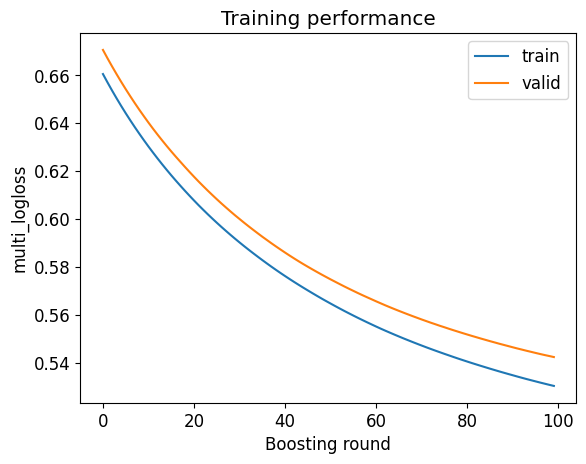

In [28]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [29]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.081767  0.195672  0.722562
1  0.089022  0.180678  0.730300
2  0.064183  0.191310  0.744506
3  0.037286  0.094449  0.868265
4  0.051012  0.194536  0.754452
0       0.081767
1       0.089022
2       0.064183
3       0.037286
4       0.051012
          ...   
7689    0.060644
7690    0.391114
7691    0.212003
7692    0.036753
7693    0.300078
Name: 0, Length: 7694, dtype: float64


In [30]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0       2
1       2
2       2
3       2
4       2
       ..
7689    2
7690    0
7691    2
7692    2
7693    2
Length: 7694, dtype: int64

In [31]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

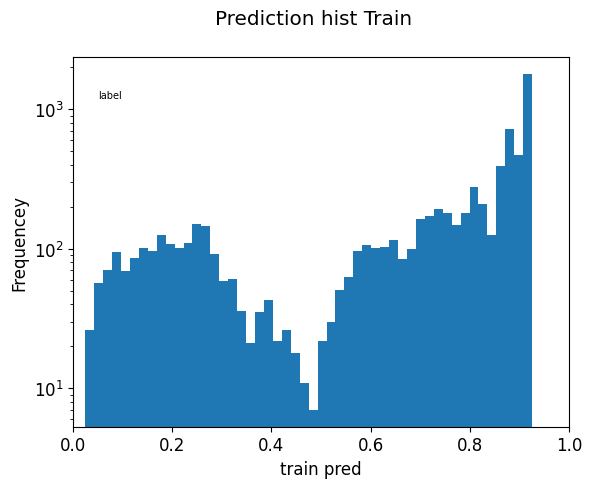

In [32]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [33]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.canvas.print_figur

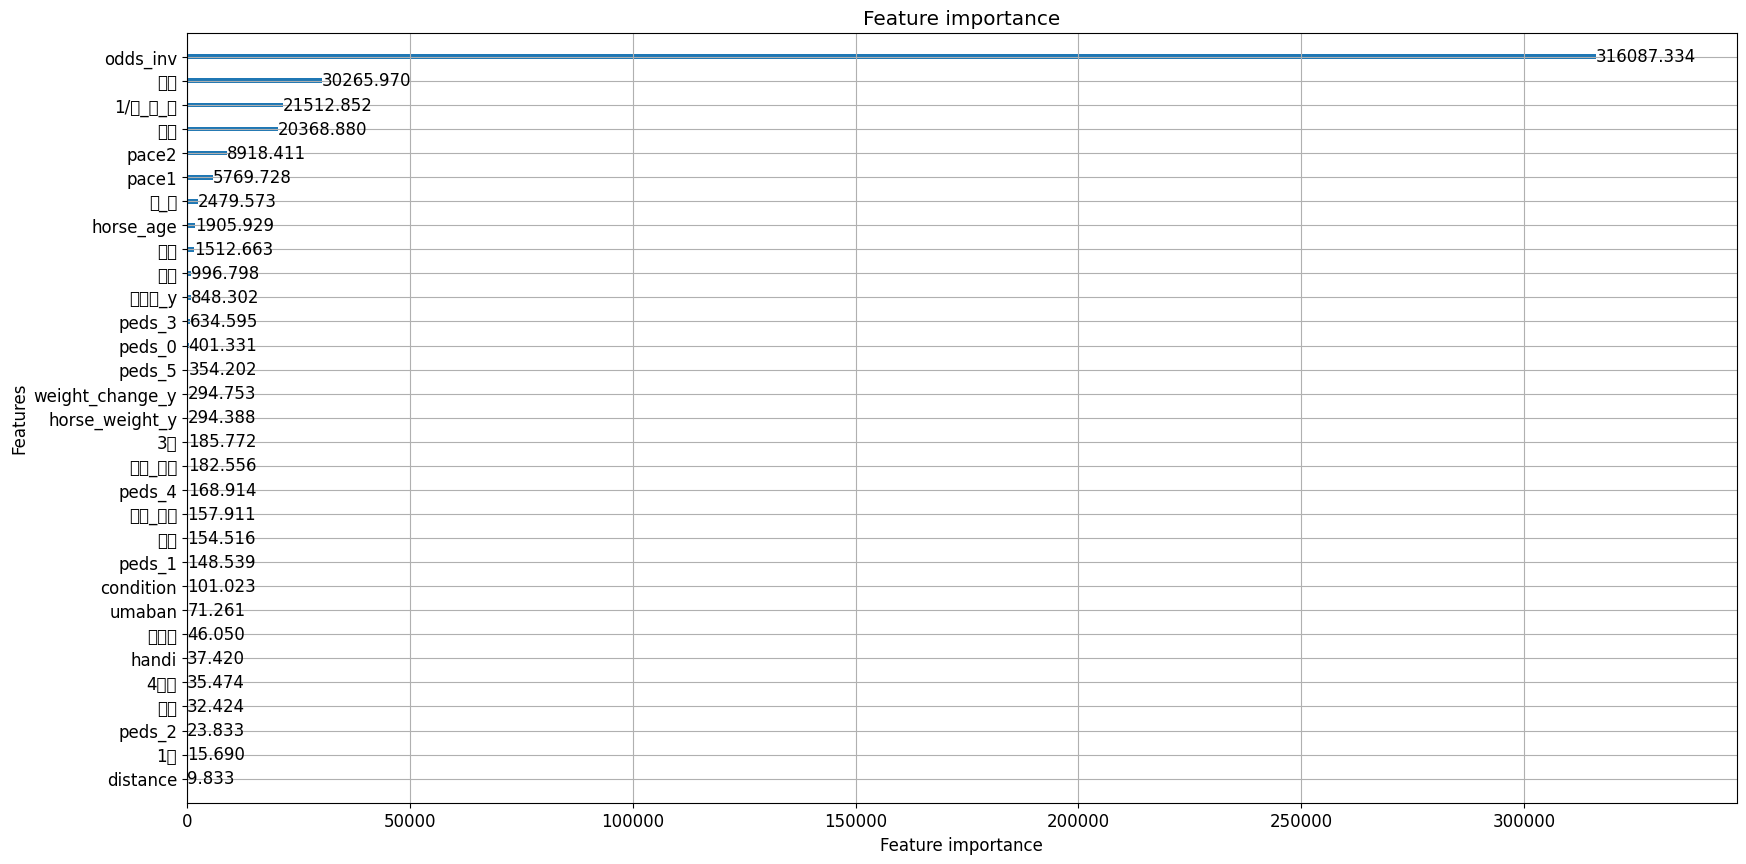

In [34]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7830777229009617


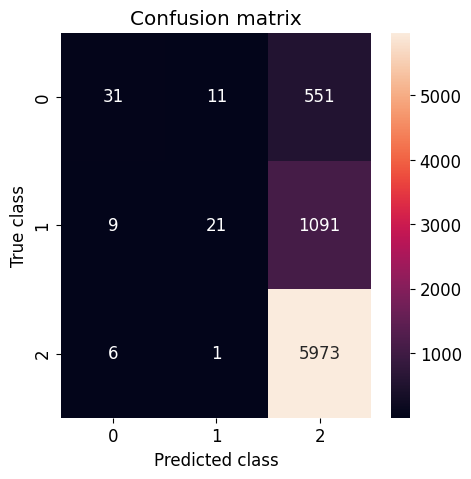

In [35]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7830777229009617


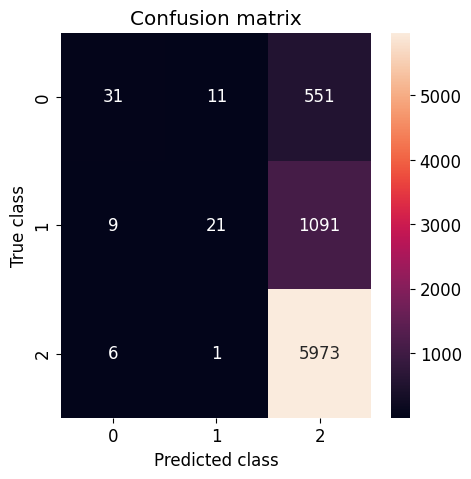

In [36]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.62      0.05      0.10      1229
           1       0.57      0.01      0.02      2422
           2       0.78      1.00      0.88     12836

    accuracy                           0.78     16487
   macro avg       0.66      0.35      0.33     16487
weighted avg       0.74      0.78      0.69     16487



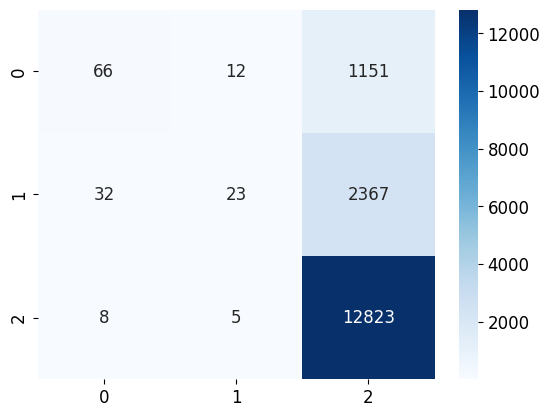

In [37]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [38]:
train_data_for_ranking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54954 entries, 0 to 115610
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-null  

In [39]:
# レースごとのオッズの特長量変換
# 追加する特長量
# log_odds: オッズの対数
# normalized_odds: オッズの正規化
# zscore_odds: オッズのzscore
# odds_rank: オッズの順位
# odds_std: オッズの標準偏差
train_data_for_ranking = odds_feature_engineering(train_data_for_ranking)


In [40]:
# 各レースごとにオッズをソートして1位、2位、3位のオッズを取得
# オッズの差分を計算して新しい特徴量として追加
odds_diff_1_2, odds_diff_1_3 = get_odds_differences(train_data_for_ranking)
train_data_for_ranking['odds_diff-1-2'] = odds_diff_1_2
train_data_for_ranking['odds_diff-1-3'] = odds_diff_1_3

# 結果を確認
# print(train_data_for_ranking[['race_id', 'odds', 'odds_diff_1_2', 'odds_diff_1_3']].head())

In [41]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
test_ranking_race_id = test_ranking["race_id"]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Resulting list of horse counts per race (sorted by date):
[8, 12, 14, 13, 10, 14, 16, 13, 9, 9, 15, 14, 8, 14, 16, 14, 6, 16, 12, 11, 10, 14, 16, 14, 9, 14, 15, 14, 14, 12, 15, 13, 14, 8, 16, 11, 14, 12, 14, 16, 12, 13, 13, 12, 14, 14, 14, 14, 14, 12, 16, 14, 10, 16, 13, 13, 9, 14, 14, 14, 14, 14, 15, 14, 7, 14, 12, 14, 11, 11, 14, 16, 9, 14, 12, 14, 13, 16, 12, 13, 9, 11, 14, 16, 7, 12, 14, 14, 10, 14, 14, 8, 11, 9, 15, 13, 12, 14, 16, 14, 11, 14, 16, 14, 14, 16, 14, 12, 11, 12, 13, 14, 9, 12, 16, 9, 14, 14, 15, 13, 11, 5, 12, 14, 13, 14, 14, 14, 14, 14, 14, 14, 9, 14, 12, 14, 5, 16, 12, 14, 16, 14, 16, 14, 8, 14, 16, 14, 13, 12, 16, 14, 16, 14, 10, 14, 11, 9, 14, 16, 14, 16, 14, 14, 14, 12, 14, 14, 16, 14, 12, 16, 11, 14, 9, 11, 8, 13, 13, 12, 16, 14, 12, 16, 11, 16, 11, 11, 16, 14, 16, 12, 16, 14, 11, 12, 14, 12, 14, 12, 11, 9, 15, 14, 14, 16, 12, 13, 11, 13, 12, 16, 11, 13, 16, 15, 10, 10, 16, 11, 5, 11, 11, 13, 8, 13, 16, 12, 16, 9, 12, 14, 6, 10, 9, 14, 13, 13, 13, 13, 9, 12, 12

In [42]:
# クエリの数の合計を確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 26926
Number of queries in valid data: 8078
Total number of queries: 2566
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [43]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

['A.' 'Abba' 'Abbatiale' ... 'ヴェルヴェットクイーン' 'ヴォークリンデ' nan]
<class 'pandas.core.frame.DataFrame'>
Index: 26926 entries, 0 to 58687
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance             26926 non-null  int64  
 1   condition            26926 non-null  int64  
 2   umaban               26926 non-null  int64  
 3   horse_age            26926 non-null  int64  
 4   horse_sex            26926 non-null  int64  
 5   handi                26926 non-null  int64  
 6   odds_inv             26926 non-null  float64
 7   weather              26926 non-null  int64  
 8   ground_state         26926 non-null  int64  
 9   天気                   26926 non-null  int64  
 10  頭 数                  26923 non-null  float64
 11  枠番                   26926 non-null  int64  
 12  馬番                   26926 non-null  int64  
 13  1/オ ッ ズ              26626 non-null  float64
 14  人気                   26818 non-nu

/home/hayato/horse_inference/scripts/utils/utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
/home/hayato/horse_inference/scripts/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['着順'] = train_data['着順'].replace('計不', 100)
/home/hayato/horse_inference/scripts/utils/utils.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<class 'pandas.core.frame.DataFrame'>
Index: 16487 entries, 82132 to 115610
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance             16487 non-null  int64  
 1   condition            16487 non-null  int64  
 2   umaban               16487 non-null  int64  
 3   horse_age            16487 non-null  int64  
 4   horse_sex            16487 non-null  int64  
 5   handi                16487 non-null  int64  
 6   odds_inv             16487 non-null  float64
 7   weather              16487 non-null  int64  
 8   ground_state         16487 non-null  int64  
 9   天気                   16487 non-null  int64  
 10  頭 数                  16485 non-null  float64
 11  枠番                   16487 non-null  int64  
 12  馬番                   16487 non-null  int64  
 13  1/オ ッ ズ              16358 non-null  float64
 14  人気                   16416 non-null  float64
 15  斤量                   16487 non-null 

In [44]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [45]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [46]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [47]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26926 entries, 0 to 58687
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         26926 non-null  int64  
 1   condition        26926 non-null  int64  
 2   umaban           26926 non-null  int64  
 3   horse_age        26926 non-null  int64  
 4   horse_sex        26926 non-null  int64  
 5   handi            26926 non-null  int64  
 6   odds_inv         26926 non-null  float64
 7   weather          26926 non-null  int64  
 8   ground_state     26926 non-null  int64  
 9   天気               26926 non-null  int64  
 10  頭 数              26923 non-null  float64
 11  枠番               26926 non-null  int64  
 12  馬番               26926 non-null  int64  
 13  1/オ ッ ズ          26626 non-null  float64
 14  人気               26818 non-null  float64
 15  斤量               26926 non-null  float64
 16  距離               26926 non-null  int64  
 17  馬場               

In [48]:
test_ranking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16487 entries, 82132 to 115610
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         16487 non-null  int64  
 1   condition        16487 non-null  int64  
 2   umaban           16487 non-null  int64  
 3   horse_age        16487 non-null  int64  
 4   horse_sex        16487 non-null  int64  
 5   handi            16487 non-null  int64  
 6   odds_inv         16487 non-null  float64
 7   weather          16487 non-null  int64  
 8   ground_state     16487 non-null  int64  
 9   天気               16487 non-null  int64  
 10  頭 数              16485 non-null  float64
 11  枠番               16487 non-null  int64  
 12  馬番               16487 non-null  int64  
 13  1/オ ッ ズ          16358 non-null  float64
 14  人気               16416 non-null  float64
 15  斤量               16487 non-null  float64
 16  距離               16487 non-null  int64  
 17  馬場          

In [49]:
# クエリの合計とデータの合計が一致しているか確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
# y_train_rankingの数とX_sorted_train_dataの数が一致しているか確認
print("y_train_ranking length {}".format(len(y_train_ranking)))
print("Number of rows in train data: {}".format(len(X_sorted_train_data)))
print("Number of rows in valid data: {}".format(len(X_sorted_valid_data)))
print("Total number of rows: {}".format(len(X_sorted_train_data) + len(X_sorted_valid_data)))

Number of queries in train data: 26926
Number of queries in valid data: 8078
y_train_ranking length 26926
Number of rows in train data: 26926
Number of rows in valid data: 8078
Total number of rows: 35004


In [50]:
# スクレイピングするごとにカラム名が変化してくので、カラム名のスペースを削除する処理を学習前に追加
# X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')

# X_sorted_valid_data.columnsの日本語文字列の半角、全角スペースを削除する
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace(' ', '')
X_sorted_valid_data.columns = X_sorted_valid_data.columns.str.replace('　', '')

# test_ranking.columnsの日本語文字列の半角、全角スペースを削除する
test_ranking.columns = test_ranking.columns.str.replace(' ', '')
test_ranking.columns = test_ranking.columns.str.replace('　', '')



In [51]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=500,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    num_leaves=10,                 # 決定木にある分岐の個数(default:31)
    max_depth=10,                  # 決定木の深さの最大値(default:-1)
    min_child_samples=40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
    # rambdalank_truncation_level=10,
    max_position=3, # 3位までの順位を予測する,
    # lambdarank_truncation_level = 5,
)

# モデルの学習
model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5822
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


LGBMRanker(max_depth=10, max_position=3, metric='ndcg', min_child_samples=40,
           n_estimators=500, num_leaves=10, objective='lambdarank',
           random_state=42)

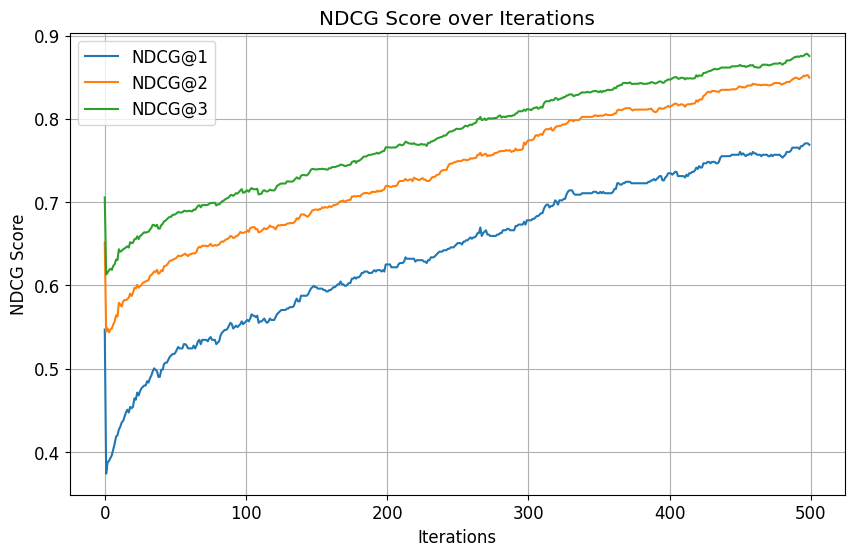

Best NDCG@1: 0.7689 in iteration: 0
Best NDCG@2: 0.8496 in iteration: 0
Best NDCG@3: 0.8755 in iteration: 0


In [52]:
# トレーニング結果の取得
evals_result = model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@2: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@2'][model.best_iteration_ - 1], model.best_iteration_))
print("Best NDCG@3: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@3'][model.best_iteration_ - 1], model.best_iteration_))

In [53]:
# アンサンブル候補①LightGBM(RankNet)
# 学習データ： X_sorted_train_data, y_train_ranking
# 学習データのクエリ： train_query
# 検証データ： X_sorted_valid_data, y_valid_ranking
# 検証データのクエリ： valid_query
# テストデータ： test_ranking, y_test_true_ranking

# LightGBMデータセット
train_data = lgb.Dataset(X_sorted_train_data, label=y_train_ranking, group=train_query)
valid_data = lgb.Dataset(X_sorted_valid_data, label=y_valid_ranking, group=valid_query)
# パラメータの設定
params = {
    'objective': 'rank_xendcg',
    'metric': 'ndcg',
    'ndcg_at': [1, 2, 3],
    'n_estimators':1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    'learning_rate':0.1,            # 学習率(default:0.1)
    'num_leaves':10,                 # 決定木にある分岐の個数(default:31)
    'max_depth':10,                  # 決定木の深さの最大値(default:-1)
    "max_position":3, # 3位までの順位を予測する
    "min_data_in_leaf":40,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # "lambdarank_truncation_level":5,
}

evaluation_results = {}
# モデルの学習
ranknet_model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.record_evaluation(evaluation_results)],
)


[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Warning] Unknown parameter: max_position
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5822
[LightGBM] [Info] Number of data points in the train set: 26926, number of used features: 48
[LightGBM] [Warning] Unknown parameter: max_position


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


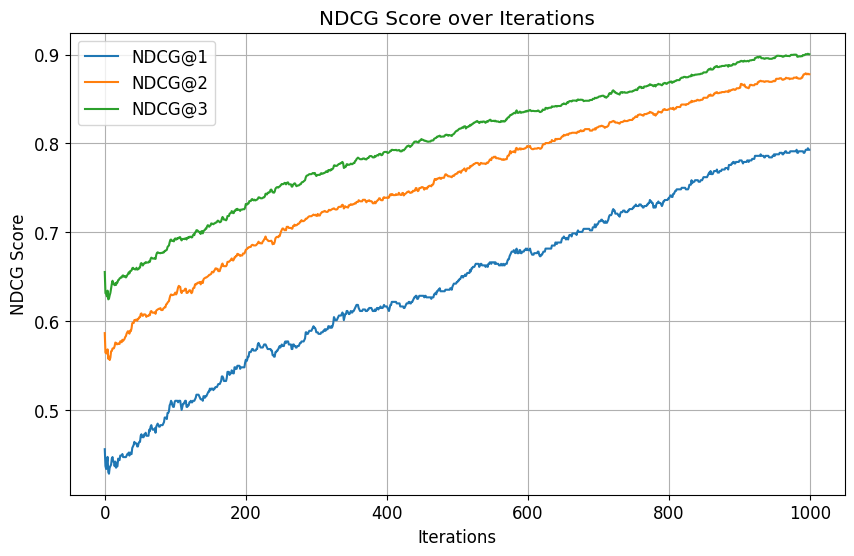

Best NDCG@1: 0.7929 in iteration: 0
Best NDCG@2: 0.8778 in iteration: 0
Best NDCG@3: 0.9003 in iteration: 0


In [54]:

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evaluation_results['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evaluation_results['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@1'], ranknet_model.best_iteration))
# 2も出力
print("Best NDCG@2: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@2'], ranknet_model.best_iteration))
# 3も出力
print("Best NDCG@3: {:.4f} in iteration: {}".format(ranknet_model.best_score['valid_0']['ndcg@3'], ranknet_model.best_iteration))


[08:46:26] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "max_position", "min_child_samples" } are not used.

[0]	validation_0-ndcg:0.70594


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-ndcg:0.78977
[200]	validation_0-ndcg:0.82640
[300]	validation_0-ndcg:0.85031
[400]	validation_0-ndcg:0.86833
[500]	validation_0-ndcg:0.88483
[600]	validation_0-ndcg:0.89360
[700]	validation_0-ndcg:0.90009
[800]	validation_0-ndcg:0.90883
[900]	validation_0-ndcg:0.91127
[999]	validation_0-ndcg:0.91307


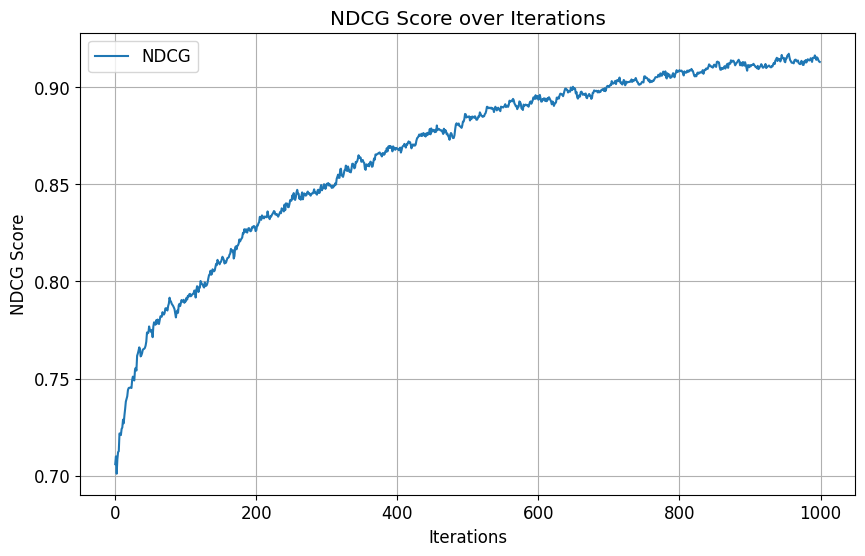

Best NDCG: 0.9173 in iteration: 955


In [55]:
# アンサンブル候補②XGBoost(Pairwise)
from xgboost import XGBRanker
# モデルの定義
pairwise_model = XGBRanker(
    objective='rank:pairwise',
    eval_metric='ndcg',
    n_estimators=1000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.1,            # 学習率(default:0.1)
    max_depth=10,                    # 決定木の深さの最大値(default:6)
    # subsample=0.8,                  # データのサンプリング比率(default:1)
    # colsample_bytree=0.8,           # 列のサンプリング比率(default:1)
    # min_child_weight=0.5,           # 葉の重みの最小値(default:1)
    # reg_lambda=1.0,                 # L2正則化の強さ(default:1)
    # gamma=0.1,                      # 葉の追加分岐を行うかの閾値(default:0)
    # n_jobs=-1,                      # 並列処理の数(default:1)
    random_state=42,                # 乱数のシード値(default:0)
    max_position=3, # 3位までの順位を予測する
    min_child_samples=30,         # 決定木のノードに含まれる最小サンプル数(default:20)
    # lambdarank_truncation_level=5,
)
# モデルの学習
pairwise_model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    verbose=100,
    early_stopping_rounds=100,
)

# 学習結果の可視化をndcgで行う
# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(pairwise_model.evals_result()['validation_0']['ndcg'], label='NDCG')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG: {:.4f} in iteration: {}".format(pairwise_model.best_score, pairwise_model.best_iteration))

[LightGBM] [Warning] Unknown parameter: max_position


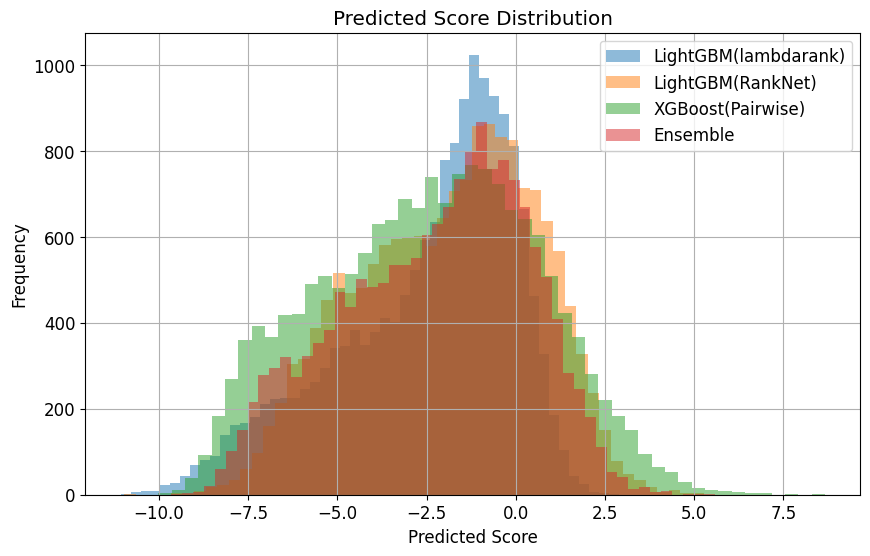

In [56]:
#　テストデータで推論
# LighGBM(lambdarank)の推論
prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)
# LightGBM(RankNet)の推論
prediction_test_ranking_ranknet = ranknet_model.predict(test_ranking)
# XGBoost(Pairwise)の推論
prediction_test_ranking_pairwise = pairwise_model.predict(test_ranking)
# 上記の平均をアンサンブルモデルとする
prediction_test_ranking_ensemble = (prediction_test_ranking + prediction_test_ranking_ranknet + prediction_test_ranking_pairwise) / 3

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア(lambdarank)": prediction_test_ranking,
    "予測スコア(RankNet)": prediction_test_ranking_ranknet,
    "予測スコア(Pairwise)": prediction_test_ranking_pairwise,
    "ensemble_prediction": prediction_test_ranking_ensemble,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
    "race_id": test_ranking_race_id,
    "distance": test_ranking["distance"],
    "ground_state": test_ranking["ground_state"],
    "weather": test_ranking["weather"],
    "condition": test_ranking["condition"],
})


# 同じレースidのうちスコアの大きい順に1位から予測順位を計算する
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(lambdarank)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(RankNet)"].rank(ascending=False, method='first')
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking.groupby("race_id")["予測スコア(Pairwise)"].rank(ascending=False, method='first')
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking.groupby("race_id")["ensemble_prediction"].rank(ascending=False, method='first')
# それぞれの予測順位はfloat型なのでint型に変換
df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測順位(lambdarank)"].astype(int)
df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測順位(RankNet)"].astype(int)
df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測順位(Pairwise)"].astype(int)
df_prediction_test_ranking["ensemble_prediction_rank"] = df_prediction_test_ranking["ensemble_prediction_rank"].astype(int)

# 3つのモデルがすべて1位と判断したときだけ1位とするアンサンブルモデル
# df_prediction_test_ranking['ensemble_prediction'] = (
#     (df_prediction_test_ranking['予測順位(lambdarank)'] == 1) &
#     (df_prediction_test_ranking['予測順位(RankNet)'] == 1) &
#     (df_prediction_test_ranking['予測順位(Pairwise)'] == 1)
# ).astype(int)

# 予測スコアの分布を可視化
plt.figure(figsize=(10, 6))
plt.hist(prediction_test_ranking, bins=50, alpha=0.5, label='LightGBM(lambdarank)')
plt.hist(prediction_test_ranking_ranknet, bins=50, alpha=0.5, label='LightGBM(RankNet)')
plt.hist(prediction_test_ranking_pairwise, bins=50, alpha=0.5, label='XGBoost(Pairwise)')
plt.hist(prediction_test_ranking_ensemble, bins=50, alpha=0.5, label='Ensemble')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.title('Predicted Score Distribution')
plt.legend()
plt.grid(True)
plt.show()



LightGBM(lambdarank)の評価
True Positive: 458
False Positive: 767
False Negative: 769
True Negative: 14493
Precision: 0.3739
Recall: 0.3733
F1 Score: 0.3736


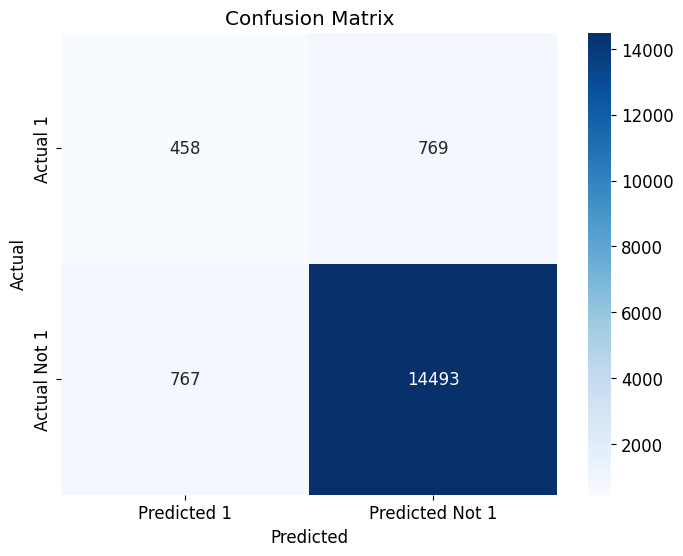

LightGBM(RankNet)の評価
True Positive: 476
False Positive: 749
False Negative: 751
True Negative: 14511
Precision: 0.3886
Recall: 0.3879
F1 Score: 0.3883


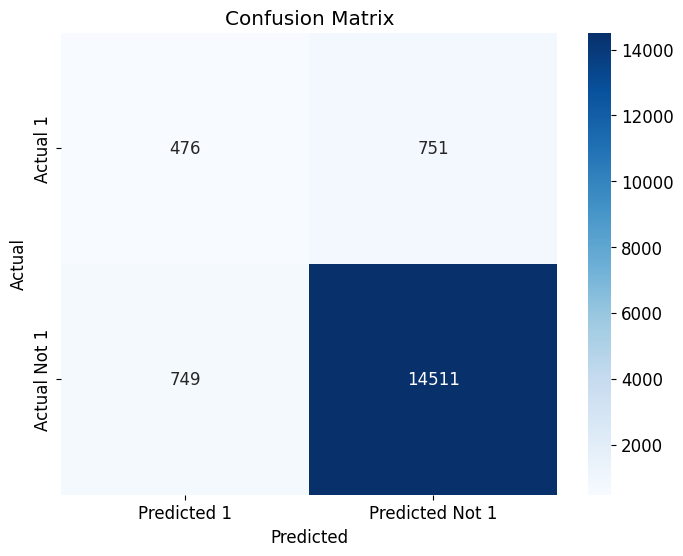

XGBoost(Pairwise)の評価
True Positive: 433
False Positive: 792
False Negative: 794
True Negative: 14468
Precision: 0.3535
Recall: 0.3529
F1 Score: 0.3532


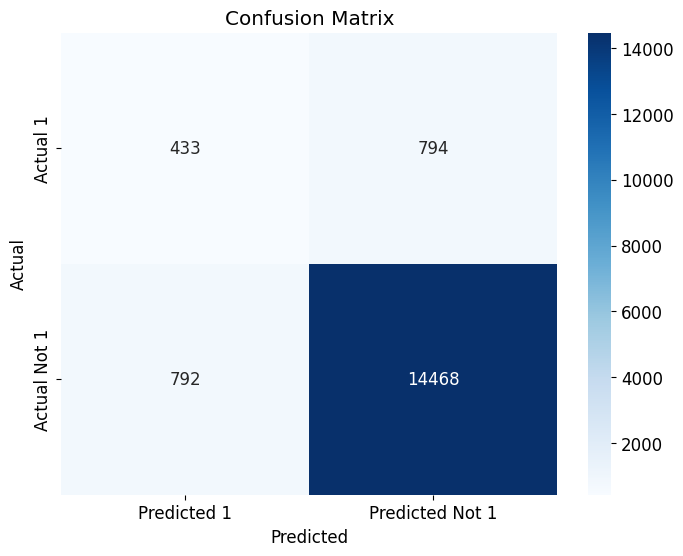

アンサンブルモデルの評価
True Positive: 473
False Positive: 752
False Negative: 754
True Negative: 14508
Precision: 0.3861
Recall: 0.3855
F1 Score: 0.3858


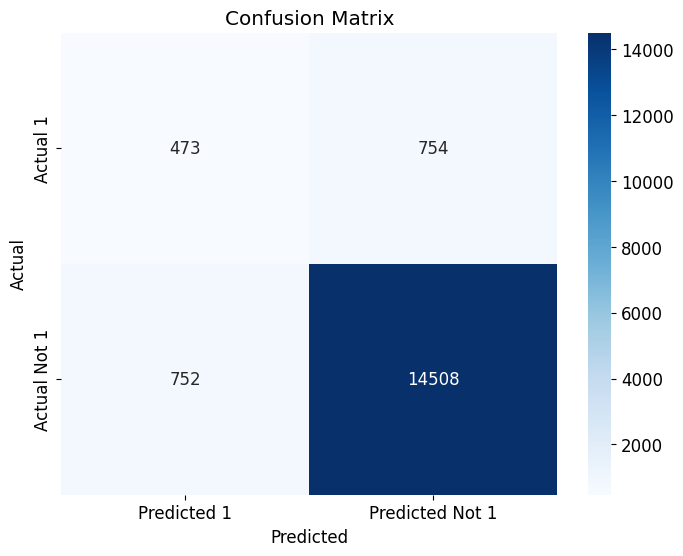

In [57]:
# 1位のスコアにおける予測結果の評価
print("LightGBM(lambdarank)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(lambdarank)')
print("LightGBM(RankNet)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(RankNet)')
print("XGBoost(Pairwise)の評価")
rank_evaluation(df_prediction_test_ranking, '予測順位(Pairwise)')
print("アンサンブルモデルの評価")
rank_evaluation(df_prediction_test_ranking, 'ensemble_prediction_rank')

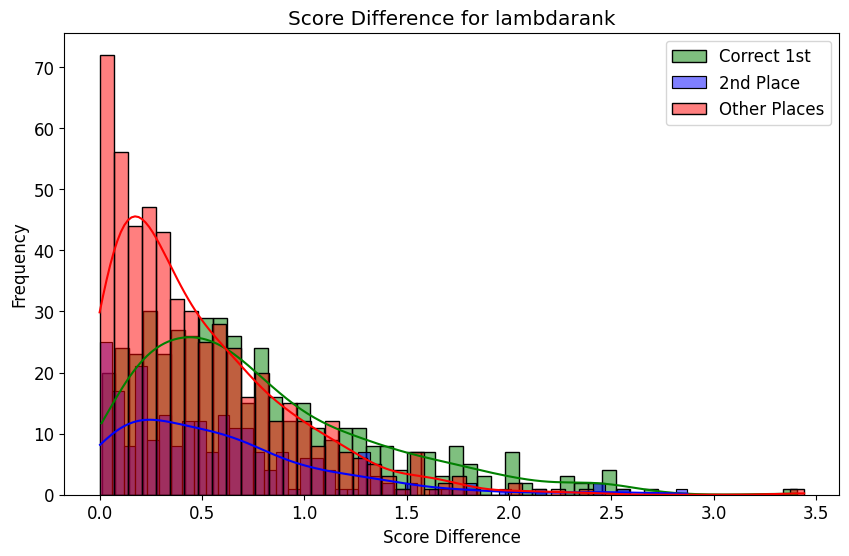

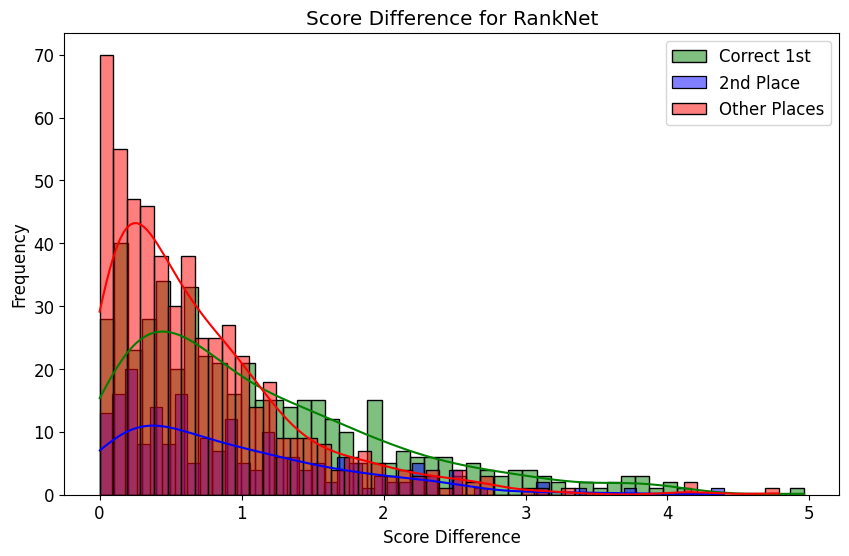

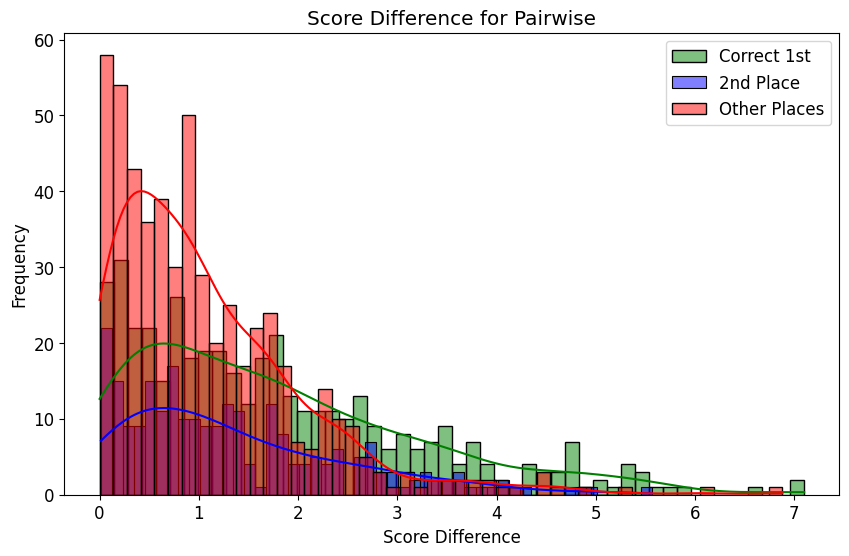

Optimal Threshold (ROC) for lambdarank: 0.6776001076416549
Optimal Threshold (Precision-Recall) for lambdarank: 0.0037143298254590507
Optimal Threshold (ROC) for RankNet: 0.9874550941307105
Optimal Threshold (Precision-Recall) for RankNet: 0.0011262936810760849
Optimal Threshold (ROC) for Pairwise: 2.328358232975006
Optimal Threshold (Precision-Recall) for Pairwise: 0.00019788742065429688
Precision for lambdarank: 0.0000
Recall for lambdarank: 0.0000
F1 Score for lambdarank: 0.0000


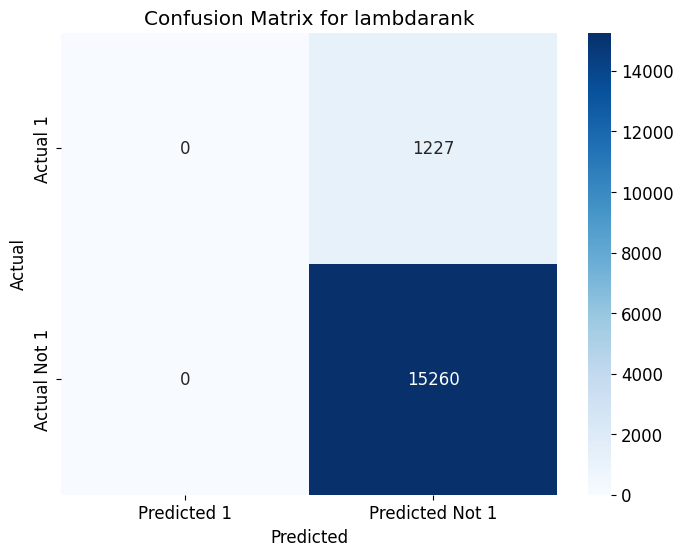

Precision for RankNet: 0.0000
Recall for RankNet: 0.0000
F1 Score for RankNet: 0.0000


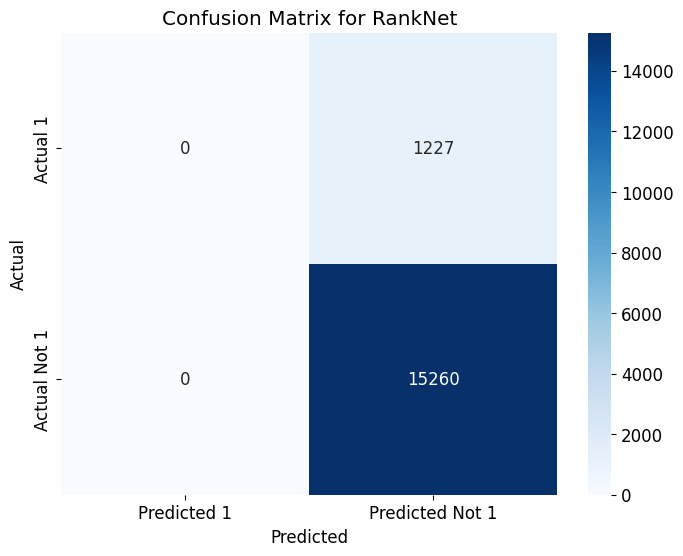

Precision for Pairwise: 0.0000
Recall for Pairwise: 0.0000
F1 Score for Pairwise: 0.0000


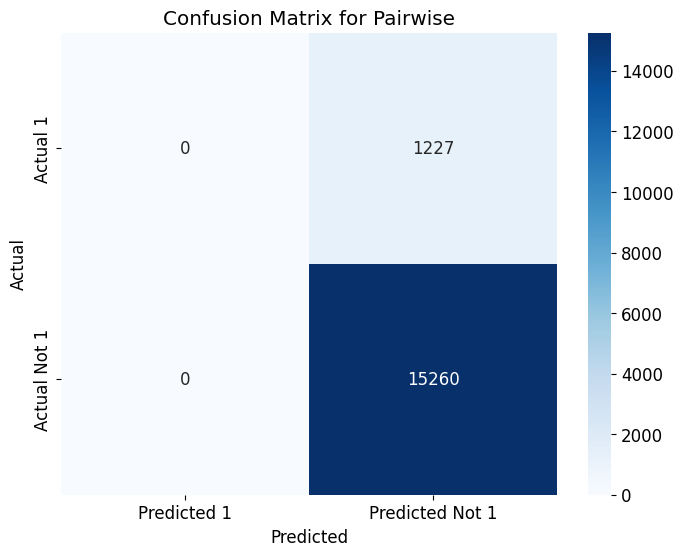

In [58]:
# 1位と2位のスコアの差を可視化する→閾値を決定してコンフュージョンマトリックスで正解率を確認する
df_prediction_test_ranking['score_diff_lambdarank'] = calculate_score_diff(df_prediction_test_ranking, 'lambdarank')
df_prediction_test_ranking['score_diff_RankNet'] = calculate_score_diff(df_prediction_test_ranking, 'RankNet')
df_prediction_test_ranking['score_diff_Pairwise'] = calculate_score_diff(df_prediction_test_ranking, 'Pairwise')

plot_score_diff(df_prediction_test_ranking, 'lambdarank')
plot_score_diff(df_prediction_test_ranking, 'RankNet')
plot_score_diff(df_prediction_test_ranking, 'Pairwise')

optimal_threshold_lambdarank, optimal_threshold_pr_lambdarank = find_optimal_threshold(df_prediction_test_ranking, 'lambdarank')
optimal_threshold_ranknet, optimal_threshold_pr_ranknet = find_optimal_threshold(df_prediction_test_ranking, 'RankNet')
optimal_threshold_pairwise, optimal_threshold_pr_pairwise = find_optimal_threshold(df_prediction_test_ranking, 'Pairwise')
print(f'Optimal Threshold (ROC) for lambdarank: {optimal_threshold_lambdarank}')
print(f'Optimal Threshold (Precision-Recall) for lambdarank: {optimal_threshold_pr_lambdarank}')
print(f'Optimal Threshold (ROC) for RankNet: {optimal_threshold_ranknet}')
print(f'Optimal Threshold (Precision-Recall) for RankNet: {optimal_threshold_pr_ranknet}')
print(f'Optimal Threshold (ROC) for Pairwise: {optimal_threshold_pairwise}')
print(f'Optimal Threshold (Precision-Recall) for Pairwise: {optimal_threshold_pr_pairwise}')

df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'lambdarank', optimal_threshold_lambdarank)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'RankNet', optimal_threshold_ranknet)
df_prediction_test_ranking = apply_threshold(df_prediction_test_ranking, 'Pairwise', optimal_threshold_pairwise)

evaluate_predictions(df_prediction_test_ranking, 'lambdarank')
evaluate_predictions(df_prediction_test_ranking, 'RankNet')
evaluate_predictions(df_prediction_test_ranking, 'Pairwise')

In [59]:
# # 1位-2位のスコア/標準偏差を計算でやってみたけどrecallがあがってprecisionが下がる結果に。
# ->未メンテ。
# evaluate_predictions_std(df_prediction_test_ranking, 'lambdarank')
# evaluate_predictions_std(df_prediction_test_ranking, 'RankNet')
# evaluate_predictions_std(df_prediction_test_ranking, 'Pairwise')

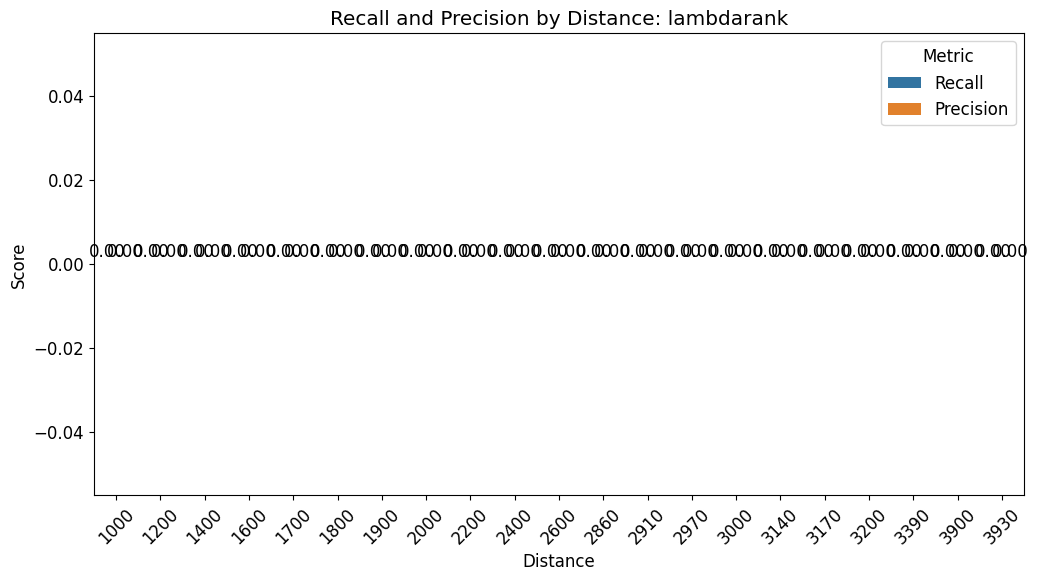

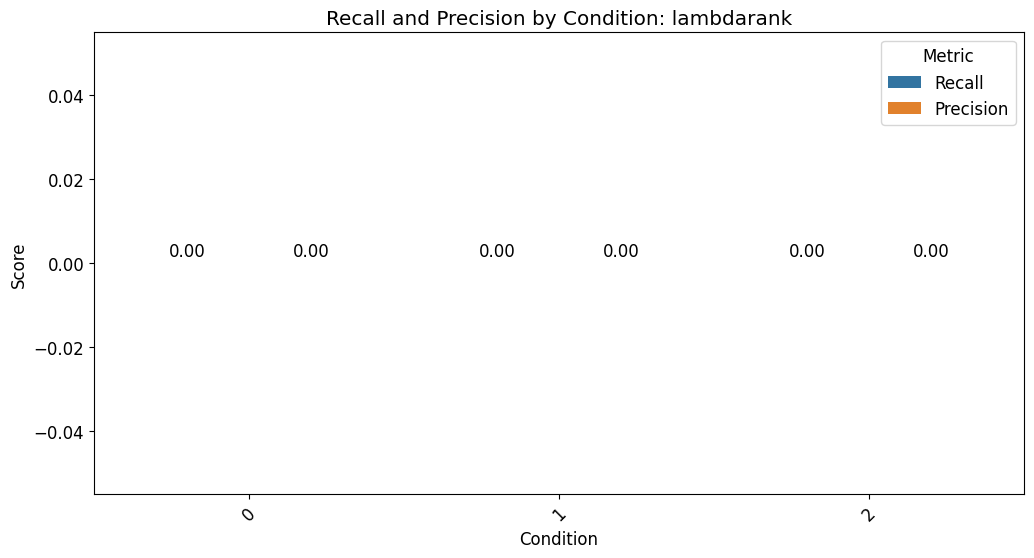

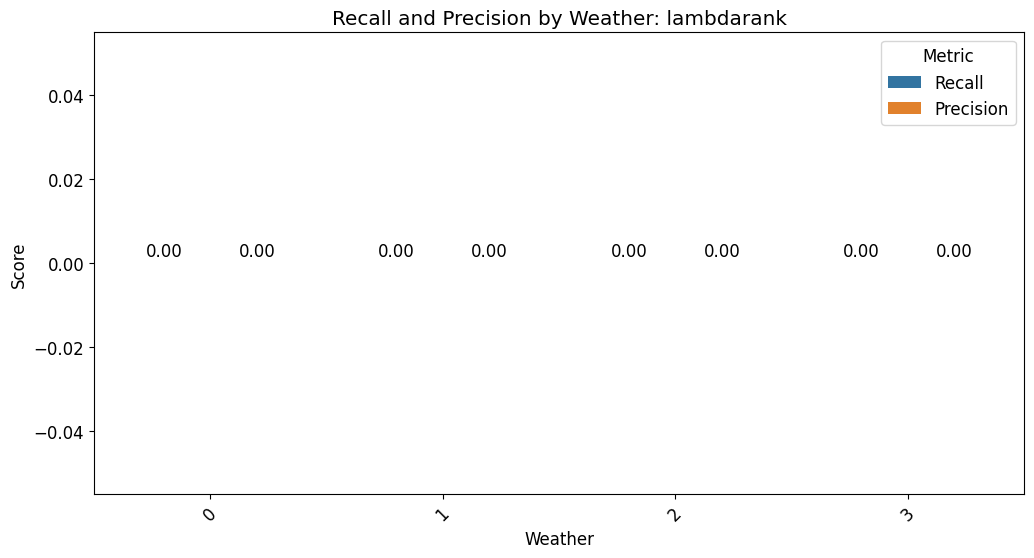

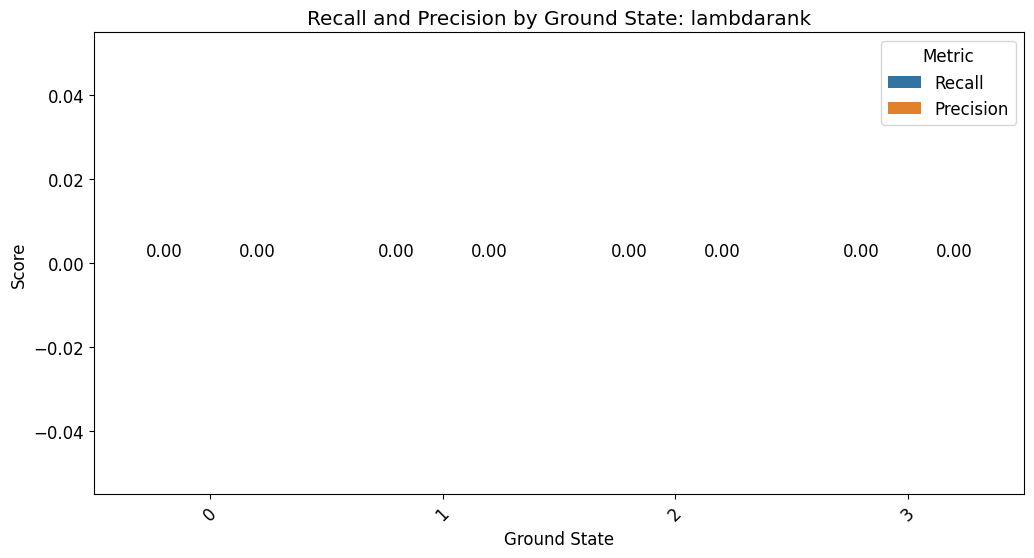

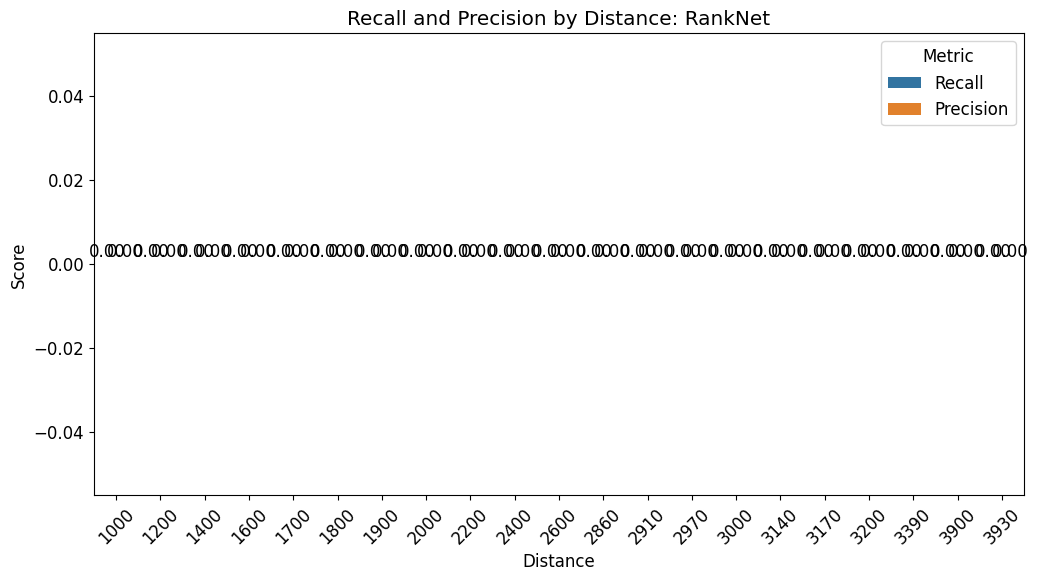

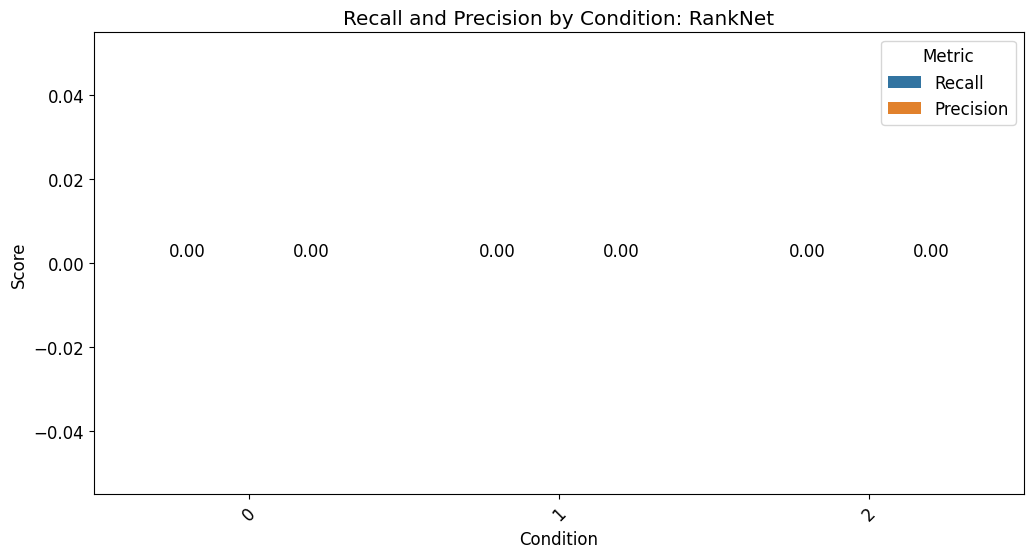

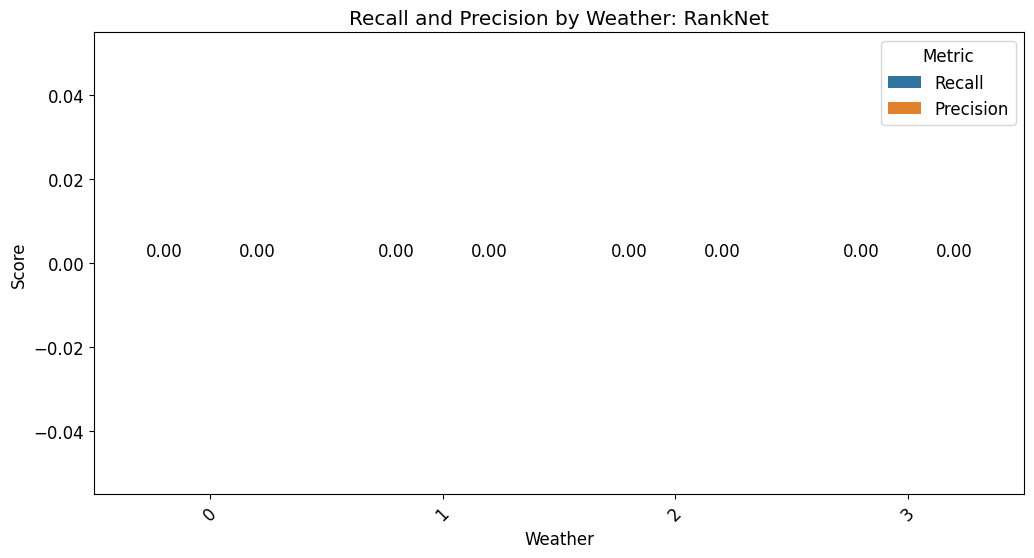

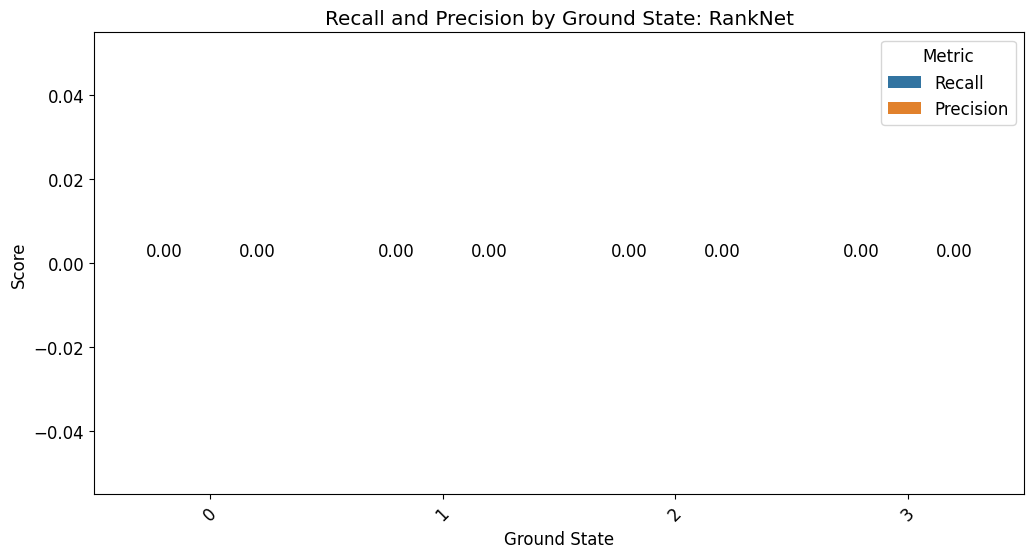

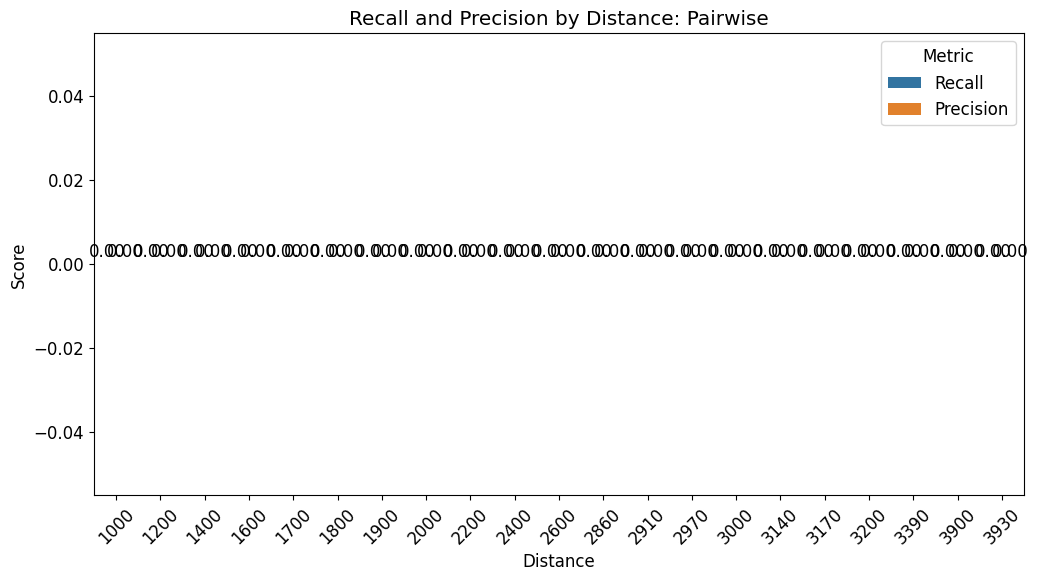

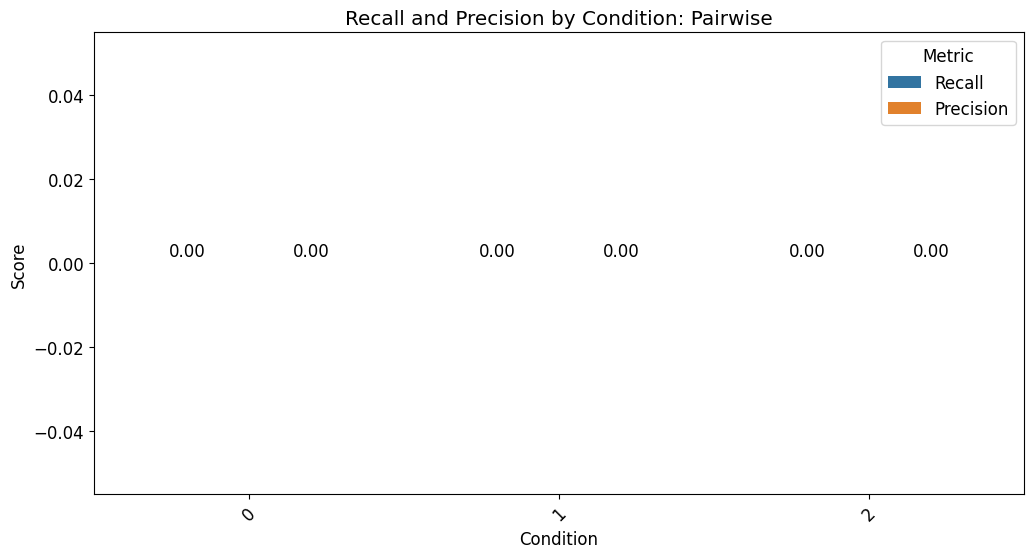

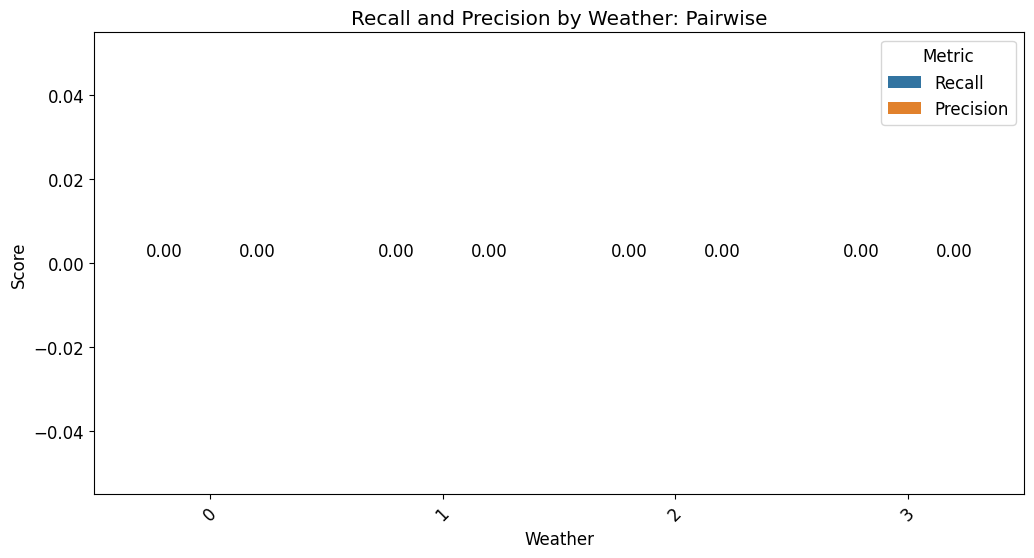

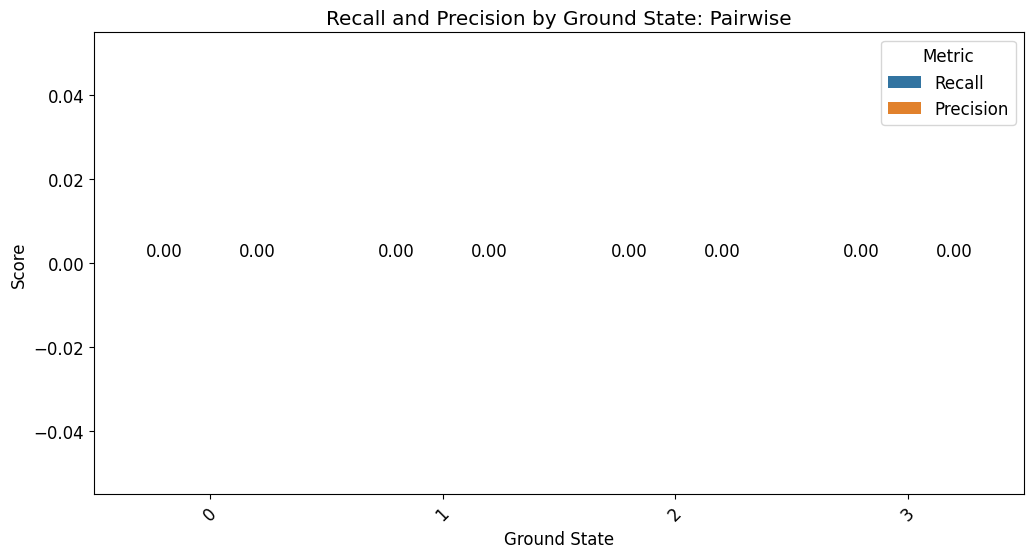

In [60]:
# 予測結果に対して距離、天気、馬場状態、コースの特長量ごとに予測精度が変わらないかを可視化する。
model_evaluation_by_feature(df_prediction_test_ranking, 'lambdarank')
model_evaluation_by_feature(df_prediction_test_ranking, 'RankNet')
model_evaluation_by_feature(df_prediction_test_ranking, 'Pairwise')

# condition
# ['ダ' '芝' '障']
# weather
# ['小雨' '晴' '曇' '雨']
# ground_state
# ['不良' '稍重' '良' '重']

In [61]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

   

# 各モデルに対して馬連のprecisionを計算
models = ['予測順位(lambdarank)', '予測順位(Pairwise)', '予測順位(RankNet)']
for model_ in models:
    umaren_precision(df_prediction_test_ranking, model_)

1225
202
precision rate 0.16489795918367348
1225
228
precision rate 0.18612244897959185
1225
222
precision rate 0.18122448979591838


In [62]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

            columns  importance
13            1/オッズ         260
19            pace1         224
45         odds_std         220
24               賞金         211
18            タイム_y         201
6          odds_inv         196
20            pace2         180
46    odds_diff-1-2         179
21               上り         174
47    odds_diff-1-3         174
22   horse_weight_y         159
23  weight_change_y         138
2            umaban         134
36           peds_1         122
39           peds_4         116
40           peds_5         105
28              4着〜         103
10               頭数          97
38           peds_3          96
0          distance          91
16               距離          89
11               枠番          86
35           peds_0          86
32               勝率          82
5             handi          76
14               人気          73
41         log_odds          72
37           peds_2          68
43      zscore_odds          66
34              複勝率          58
3       

In [63]:
# カレントディレクトリにモデルを保存
import pickle
with open('pkl_registory/lambdarank_model.pkl', 'wb') as f:
    pickle.dump(model, f)
# カレントディレクトリにranknet_modelモデルを保存
with open('pkl_registory/ranknet_model.pkl', 'wb') as f:
    pickle.dump(ranknet_model, f)
# カレントディレクトリにpairwise_modelモデルを保存
with open('pkl_registory/pairwise_model.pkl', 'wb') as f:
    pickle.dump(pairwise_model, f)

In [ ]:
from pathlib import Path
import pandas as pd
import tqdm
from utils.utils_inference import *

# 青色で出力
# "RankNetの正答率が高い"
print("\033[34m二つのモデルで1位が出てくるときはオッズがつくならワイドあり\033[0m")
# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
print(p)
print(files)
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    # print("=======予測ファイル名======== {}".format(file))
    print("=======予測ファイル名========\n {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    # print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data, inference_data_odds, inference_data_race_id,inference_data_answer = preprocess_for_inference(inference_data)
    # オッズの差分を計算して新しい特徴量として追加
    inference_data = add_odds_differences_for_inference(inference_data)
    

    # X_sorted_train_data.columnsの日本語文字列の半角、全角スペースを削除する
    # X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace(' ', '')
    # X_sorted_train_data.columns = X_sorted_train_data.columns.str.replace('　', '')
    

    # inference_dataの特長量を設定する
    inference_data = inference_data[X_sorted_train_data.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])
    # print(inference_data.info())

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = model.predict(inference_data, num_iteration=model.best_iteration_)
    prediction_inference_ranking_ranknet = ranknet_model.predict(inference_data)
    prediction_inference_ranking_pairwise = pairwise_model.predict(inference_data)
    # シンプルに予測結果の平均を取る
    prediction_inference = (prediction_inference_ranking + prediction_inference_ranking_ranknet + prediction_inference_ranking_pairwise) / 3
    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "horse_id": inference_data["umaban"],
        "予測スコア(lambdarank)": prediction_inference_ranking,
        "予測スコア(RankNet)": prediction_inference_ranking_ranknet,
        "予測スコア(Pairwise)": prediction_inference_ranking_pairwise,
        "predict_amsamble": prediction_inference,
        "odds": inference_data_odds,
        "goal": inference_data_answer,
        "race_id": inference_data_race_id,
        "distance": inference_data["distance"],
        "condition": inference_data["condition"],
        "weather": inference_data["weather"],
        "ground_state": inference_data["ground_state"],
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(lambdarank)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(lambdarank)"] = df_prediction_test_ranking["予測スコア(lambdarank)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(RankNet)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(RankNet)"] = df_prediction_test_ranking["予測スコア(RankNet)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア(Pairwise)", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(Pairwise)"] = df_prediction_test_ranking["予測スコア(Pairwise)"].rank(ascending=False, method='first').astype(int)
    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="predict_amsamble", ascending=False)
    # 予測順位を計算
    df_prediction_test_ranking["予測順位(amsamble)"] = df_prediction_test_ranking["predict_amsamble"].rank(ascending=False, method='first').astype(int)
    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)
    # 最後に着順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="goal")

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)
    file_name = file.name
    saving_path = inference_data_path_result + "prediction_" +  str(file_name) + "_.csv"
    # print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)

    # 推論データに対して予測を行う。1位と2位のスコアの差を計算し、閾値を適用して各モデルごとに1位を予測する
    df_prediction_test_ranking = prediction_print(df_prediction_test_ranking,optimal_threshold_lambdarank,optimal_threshold_ranknet,optimal_threshold_pairwise)

    # =================================================================
    # 予測結果がシビアすぎて全然買い目が出ないので過去の情報も一応出力しておく
    # =================================================================
    # すべてのモデルのスコアが正で1位かつスコアが0以上のものをフィルタリング
    # utils_inference.add_prediction_info(df_prediction_test_ranking)

    count +=1


二つのモデルで1位が出てくるときはオッズがつくならワイドあり
/home/hayato/horse_inference/inference/2025060201/add_dynamic_data
[PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602018.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_202506020110.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602015.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602016.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602011.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602017.csv'), PosixPath('/home/hayato/horse_inference/inference/2025060201

  0%|          | 0/11 [00:00<?, ?it/s]

=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602019.csv
[LightGBM] [Warning] Unknown parameter: max_position
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602018.csv


 27%|██▋       | 3/11 [00:00<00:00, 19.65it/s]

[LightGBM] [Warning] Unknown parameter: max_position
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_202506020110.csv
[LightGBM] [Warning] Unknown parameter: max_position
=======予測ファイル名========
 /home/hayato/horse_inference/inference/2025060201/add_dynamic_data/updated_inference_data_20250602015.csv


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: 1着: object, 2着: object, 3着: object, 4着〜: object, 騎乗回数: object, 重賞出走: object, 重賞勝利: object